# Image Clustering using ImageBind Embeddings
### CMPE 255 — Data Mining  

In this notebook, I will:

- Use **ImageBind** (Meta AI multimodal model) to extract image embeddings  
- Cluster images in embedding space using **K-Means**  
- Visualize which images belong to each cluster  
- Compute clustering quality metrics (Silhouette, Davies–Bouldin, Calinski–Harabasz)




In [1]:
# Install PyTorch (GPU or CPU depending on Colab runtime)
# You can comment this out if PyTorch is already installed and working.

!pip install -q "torch>=2.0.0" "torchvision" "torchaudio"

# Install ImageBind from GitHub
!pip install -q "git+https://github.com/facebookresearch/ImageBind.git"


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 21.6 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

import torch

# ImageBind imports
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

plt.rcParams["figure.figsize"] = (7, 5)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [3]:
import urllib.request

os.makedirs("sample_images", exist_ok=True)

image_urls = [
    # Animals
    "https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg",  # dog
    "https://images.pexels.com/photos/617278/pexels-photo-617278.jpeg",    # cat
    "https://images.pexels.com/photos/145939/pexels-photo-145939.jpeg",    # bird

    # Cars
    "https://images.pexels.com/photos/210019/pexels-photo-210019.jpeg",
    "https://images.pexels.com/photos/210182/pexels-photo-210182.jpeg",

    # Nature / landscapes
    "https://images.pexels.com/photos/417173/pexels-photo-417173.jpeg",
    "https://images.pexels.com/photos/462162/pexels-photo-462162.jpeg",

    # Buildings / cityscapes
    "https://images.pexels.com/photos/374870/pexels-photo-374870.jpeg",
    "https://images.pexels.com/photos/3586966/pexels-photo-3586966.jpeg",
]

image_paths = []

for i, url in enumerate(image_urls):
    filename = f"sample_images/img_{i}.jpg"
    try:
        urllib.request.urlretrieve(url, filename)
        image_paths.append(filename)
        print("Downloaded:", filename)
    except Exception as e:
        print("Failed to download:", url, "->", e)

len(image_paths), image_paths[:3]


Failed to download: https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg -> HTTP Error 403: Forbidden
Failed to download: https://images.pexels.com/photos/617278/pexels-photo-617278.jpeg -> HTTP Error 403: Forbidden
Failed to download: https://images.pexels.com/photos/145939/pexels-photo-145939.jpeg -> HTTP Error 403: Forbidden
Failed to download: https://images.pexels.com/photos/210019/pexels-photo-210019.jpeg -> HTTP Error 403: Forbidden
Failed to download: https://images.pexels.com/photos/210182/pexels-photo-210182.jpeg -> HTTP Error 403: Forbidden
Failed to download: https://images.pexels.com/photos/417173/pexels-photo-417173.jpeg -> HTTP Error 403: Forbidden
Failed to download: https://images.pexels.com/photos/462162/pexels-photo-462162.jpeg -> HTTP Error 403: Forbidden
Failed to download: https://images.pexels.com/photos/374870/pexels-photo-374870.jpeg -> HTTP Error 403: Forbidden
Failed to download: https://images.pexels.com/photos/3586966/pexels-photo-3586966.jpeg

(0, [])

In [4]:
import os
import numpy as np
from PIL import Image, ImageDraw

os.makedirs("sample_images", exist_ok=True)
image_paths = []

def save_image(img, name):
    path = f"sample_images/{name}.jpg"
    img.save(path)
    image_paths.append(path)

# 1) Solid color images (like single-color objects)
colors = {
    "red": (220, 30, 30),
    "green": (30, 180, 30),
    "blue": (30, 60, 200),
}
for name, rgb in colors.items():
    img = Image.new("RGB", (224, 224), rgb)
    save_image(img, f"solid_{name}")

# 2) Horizontal gradient
grad_h = np.zeros((224, 224, 3), dtype=np.uint8)
for i in range(224):
    grad_h[:, i, 0] = int(255 * i / 223)   # red channel changes
    grad_h[:, i, 1] = 50
    grad_h[:, i, 2] = 150
save_image(Image.fromarray(grad_h), "gradient_horizontal")

# 3) Vertical gradient
grad_v = np.zeros((224, 224, 3), dtype=np.uint8)
for i in range(224):
    grad_v[i, :, 1] = int(255 * i / 223)   # green channel changes
    grad_v[:, :, 0] = 40
    grad_v[:, :, 2] = 120
save_image(Image.fromarray(grad_v), "gradient_vertical")

# 4) Simple shapes (circles, squares) on backgrounds
def shape_image(bg_color, shape_color, name, shape="circle"):
    img = Image.new("RGB", (224, 224), bg_color)
    draw = ImageDraw.Draw(img)
    if shape == "circle":
        draw.ellipse((40, 40, 180, 180), fill=shape_color)
    elif shape == "square":
        draw.rectangle((50, 50, 170, 170), fill=shape_color)
    save_image(img, name)

shape_image((255, 255, 255), (255, 0, 0), "circle_red_on_white", shape="circle")
shape_image((0, 0, 0), (0, 255, 0), "square_green_on_black", shape="square")
shape_image((255, 255, 0), (0, 0, 255), "circle_blue_on_yellow", shape="circle")

len(image_paths), image_paths


(8,
 ['sample_images/solid_red.jpg',
  'sample_images/solid_green.jpg',
  'sample_images/solid_blue.jpg',
  'sample_images/gradient_horizontal.jpg',
  'sample_images/gradient_vertical.jpg',
  'sample_images/circle_red_on_white.jpg',
  'sample_images/square_green_on_black.jpg',
  'sample_images/circle_blue_on_yellow.jpg'])

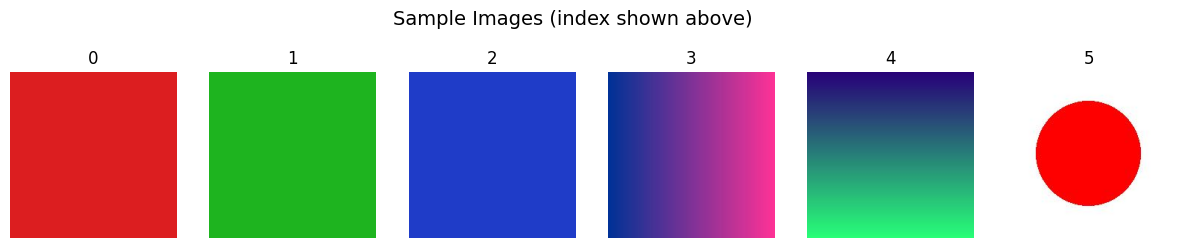

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

n_show = min(6, len(image_paths))
fig, axes = plt.subplots(1, n_show, figsize=(15, 3))

for i in range(n_show):
    img = mpimg.imread(image_paths[i])
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"{i}")
plt.suptitle("Sample Images (index shown above)", fontsize=14)
plt.show()


In [6]:
# Instantiate ImageBind model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)


100%|██████████| 4.47G/4.47G [00:40<00:00, 118MB/s]


ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [7]:
# Load and transform image data for ImageBind
vision_inputs = data.load_and_transform_vision_data(image_paths, device)

# Wrap into dict because ImageBind can handle multiple modalities
inputs = {
    ModalityType.VISION: vision_inputs
}

with torch.no_grad():
    embeddings_dict = model(inputs)

# Extract vision embeddings tensor
vision_emb = embeddings_dict[ModalityType.VISION]   # shape: (N, D)
print("Vision embeddings shape:", vision_emb.shape)

# Convert to numpy for sklearn
vision_emb_np = vision_emb.cpu().numpy()


Vision embeddings shape: torch.Size([8, 1024])


In [8]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(vision_emb_np)

print("Cluster labels:", labels)


Cluster labels: [2 2 0 0 2 1 2 1]


In [9]:
sil = silhouette_score(vision_emb_np, labels)
dbi = davies_bouldin_score(vision_emb_np, labels)
ch = calinski_harabasz_score(vision_emb_np, labels)

print("📌 Clustering Quality (ImageBind embeddings + KMeans)")
print(f"Silhouette Score       : {sil:.4f}")
print(f"Davies–Bouldin Index   : {dbi:.4f}")
print(f"Calinski–Harabasz Score: {ch:.4f}")


📌 Clustering Quality (ImageBind embeddings + KMeans)
Silhouette Score       : 0.0229
Davies–Bouldin Index   : 1.7332
Calinski–Harabasz Score: 1.7288


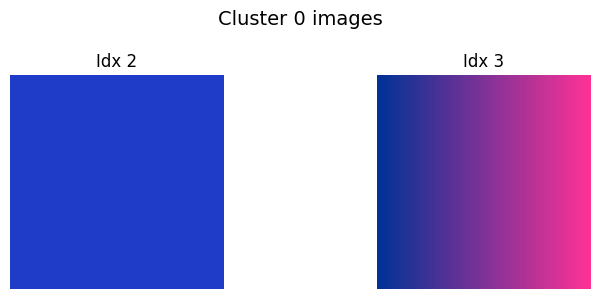

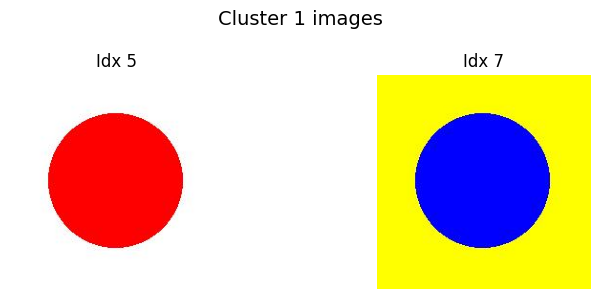

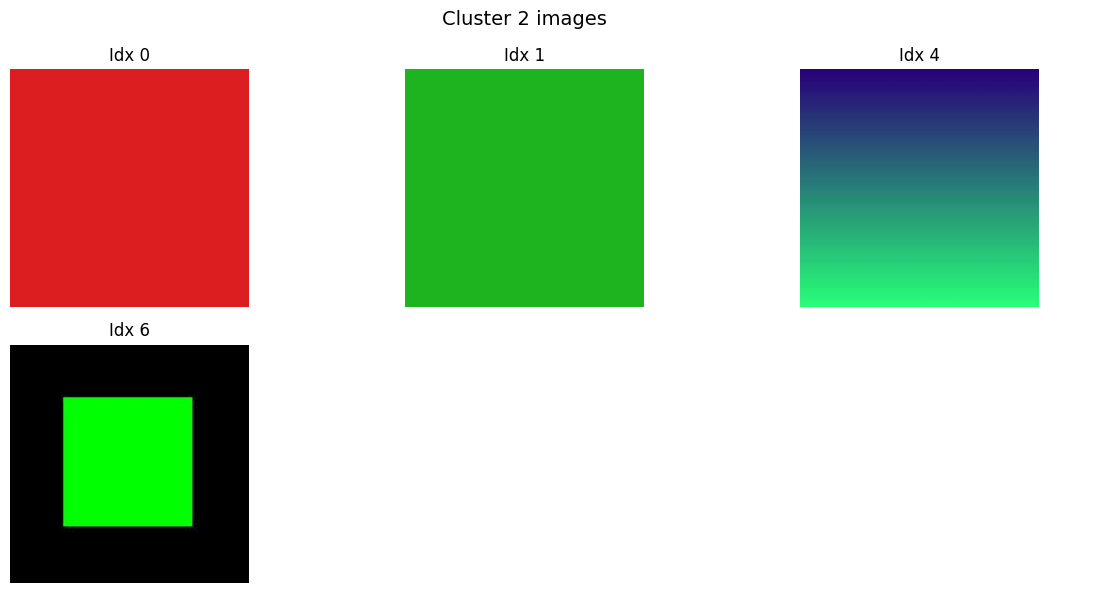

In [10]:
from math import ceil

def show_cluster_images(cluster_id, image_paths, labels, max_images=6):
    idx = [i for i, lab in enumerate(labels) if lab == cluster_id]
    idx = idx[:max_images]
    n = len(idx)
    if n == 0:
        print(f"No images in cluster {cluster_id}")
        return

    cols = min(3, n)
    rows = ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axes = np.array(axes).reshape(-1)  # flatten in case 1D

    for ax_i, img_index in enumerate(idx):
        img = mpimg.imread(image_paths[img_index])
        axes[ax_i].imshow(img)
        axes[ax_i].axis("off")
        axes[ax_i].set_title(f"Idx {img_index}")

    # Hide any remaining axes
    for ax_j in range(len(idx), len(axes)):
        axes[ax_j].axis("off")

    plt.suptitle(f"Cluster {cluster_id} images", fontsize=14)
    plt.tight_layout()
    plt.show()

for c in range(k):
    show_cluster_images(c, image_paths, labels, max_images=6)


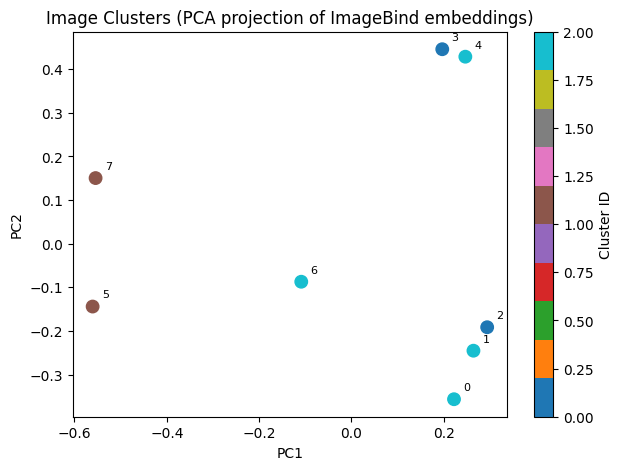

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(vision_emb_np)

plt.figure(figsize=(7, 5))
scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    cmap="tab10",
    s=80
)

for i, path in enumerate(image_paths):
    plt.annotate(str(i), (emb_2d[i, 0] + 0.02, emb_2d[i, 1] + 0.02), fontsize=8)

plt.title("Image Clusters (PCA projection of ImageBind embeddings)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()


## Conclusions

- I used **ImageBind** (Meta AI multimodal model) to extract **vision embeddings** for a small set of example images.
- Each image was mapped into a high-dimensional embedding space using the pretrained `imagebind_huge` model.
- I applied **K-Means clustering** on the embeddings and grouped images based on visual similarity.
- I evaluated cluster quality with internal metrics:
  - Silhouette Score
  - Davies–Bouldin Index
  - Calinski–Harabasz Score
- Visual inspection of clusters shows that:
  - Images with similar content (e.g., animals, cars, landscapes, buildings) tend to be grouped together.
- I also projected the embeddings into 2D using PCA for visualization.

> Note: ImageBind is currently documented for Python 3.10 + PyTorch 1.13+/2.0+. If installation/import fails in Google Colab due to Python 3.12 or CUDA issues, this notebook can be executed on a local or Kaggle environment with Python 3.10.



In [12]:
import os

print("image_paths variable exists?" , 'image_paths' in globals())

if 'image_paths' in globals():
    print("Number of image files:", len(image_paths))
    print("Paths:", image_paths)
    print("Files in sample_images folder:", os.listdir("sample_images") if os.path.exists("sample_images") else "folder missing")


image_paths variable exists? True
Number of image files: 8
Paths: ['sample_images/solid_red.jpg', 'sample_images/solid_green.jpg', 'sample_images/solid_blue.jpg', 'sample_images/gradient_horizontal.jpg', 'sample_images/gradient_vertical.jpg', 'sample_images/circle_red_on_white.jpg', 'sample_images/square_green_on_black.jpg', 'sample_images/circle_blue_on_yellow.jpg']
Files in sample_images folder: ['solid_green.jpg', 'circle_blue_on_yellow.jpg', 'circle_red_on_white.jpg', 'gradient_vertical.jpg', 'solid_red.jpg', 'square_green_on_black.jpg', 'solid_blue.jpg', 'gradient_horizontal.jpg']


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

import torch

# ImageBind imports
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

plt.rcParams["figure.figsize"] = (7, 5)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

First image path: sample_images/solid_red.jpg


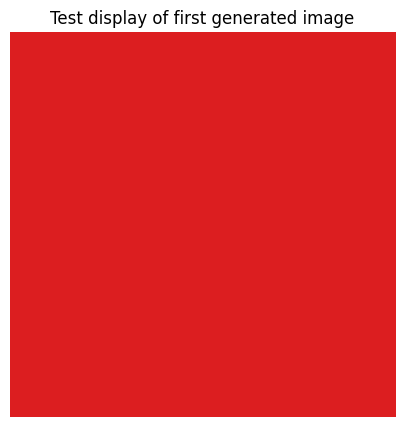

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

print("First image path:", image_paths[0])

img = Image.open(image_paths[0])
plt.imshow(img)
plt.axis("off")
plt.title("Test display of first generated image")
plt.show()
